In [1]:
%load_ext autoreload
%autoreload 2
import xgboost as xgb
import pandas as pd
import numpy as np
from utils import k_fold_cross_validation_classification, acc_pre_rec

/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df_train = pd.read_csv('data/data_processed_train_merged.csv')


df_train = df_train[df_train['mode'] != np.nan]
df = df_train
string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)



In [4]:
df_train

,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,num_travelers,...,num_students,disability,trip_distance,mode,trip_distance_category,age_merged,income_aggregate_merged,res_type_merged,education_merged,travel_date_dow_merged
0,0,0,0,30/05/2019,4,7,2,0,1,1,...,2,3,13.4,subway,long,1,1,0,1,0
1,1,0,1,01/06/2019,6,6,1,0,1,1,...,2,3,3.7,drive,long,1,1,0,1,1
2,2,0,2,02/06/2019,7,7,7,1,2,3,...,2,3,9.8,drive,long,1,1,0,1,1
3,3,0,3,02/06/2019,7,7,7,1,2,3,...,2,3,11.1,drive,long,1,1,0,1,1
4,4,0,4,03/06/2019,1,7,7,0,1,1,...,2,3,2.5,drive,medium,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39439,39493,1794,53,07/06/2019,5,6,6,0,2,2,...,0,3,0.5,walk,short,1,0,2,1,0
39440,39494,1794,54,07/06/2019,5,6,6,0,2,2,...,0,3,0.5,walk,short,1,0,2,1,0
39441,39495,1794,55,07/06/2019,5,6,6,0,2,2,...,0,3,0.2,walk,short,1,0,2,1,0
39442,39496,1794,56,07/06/2019,5,6,8,0,2,2,...,0,3,1.1,walk,medium,1,0,2,1,0


In [9]:
TRANSPORT_MODES = ['drive', 'passenger', 'bus', 'subway', 'bike', 'walk', 'other']
candidate_cols = [
#      'travel_date_dow',
     'o_purpose_category',
     'd_purpose_category',
     'num_non_hh_travelers',
     'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
     'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
     'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
#      'res_type',
#      'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
    'trip_distance',
    'res_type_merged',
    'income_aggregate_merged',
    'age_merged',
    'travel_date_dow_merged',
    'education_merged']

categorial_columns = ['travel_date_dow',
       'o_purpose_category', 'd_purpose_category', 'o_location_type',
       'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry', 'gender'
                    , 'survey_language',
       'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X_train_val = onehot.to_numpy()[:len(df_train)]
y_train_val = df['mode'][:len(df_train)].apply(lambda x: TRANSPORT_MODES.index(x))
group = df['person_id'].to_numpy()[:len(df_train)]




XGBoost parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

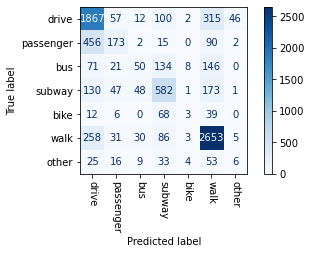

In [10]:
model = xgb.XGBClassifier(objective='multi:softprob',
                          n_estimators = 100,
                          n_jobs=-1,
                          learning_rate=0.138,
                          num_class=7,
                          random_state=42,
                          eval_metric=['mlogloss', 'merror'],
                          use_label_encoder =False)


train_metrics, val_metrics = k_fold_cross_validation_classification(X_train_val,
                                                                    y_train_val,
                                                                    group,
                                                                    model,
                                                                    confusion_matrix_save_path='image/xgboost_mode_confusion.eps',
                                                                    display_labels=TRANSPORT_MODES)

In [12]:
train_metrics

[(0.7611155125970528, 0.6727377834094703),
 (0.7581682776105213, 0.6719154978382755),
 (0.7592140706702583, 0.6733937013323513),
 (0.7656155918237997, 0.6499189444254028),
 (0.7595702877424262, 0.6694290154805509)]

In [13]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 2, 1, 3]]

df_metrics = pd.DataFrame(metrics, columns=['acc-train', 'acc-val', 'cross entropy-train', 'cros entropy-val'])

In [14]:
df_metrics

,acc-train,acc-val,cross entropy-train,cros entropy-val
0,0.761116,0.676131,0.672738,0.897346
1,0.758168,0.688680,0.671915,0.914249
2,0.759214,0.699328,0.673394,0.887239
3,0.765616,0.663075,0.649919,1.019858
4,0.759570,0.688007,0.669429,0.909351


In [16]:
df_metrics.to_csv('stats/xgboost_mode_ground_truth_merged.csv')